In [21]:
import numpy as np
import pandas as pd
import plotly.express as px
from plotly.offline import plot
from plotly.utils import PlotlyJSONEncoder
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import dash_bio


# 加载数据
df = pd.read_csv('./mt_RPKM.txt',sep='\t').copy()
df1 = pd.read_csv('./demo_RPKM_1.txt',sep='\t').copy()
df2 =  pd.read_csv('./demo_RPKM_2.txt',sep='\t').copy()

### dush-bio 
- 没啥用

In [22]:
import pandas as pd
import dash_bio

dash_bio.Clustergram(
    data=df,
    column_labels=list(df.columns.values),
    row_labels=list(df.index),
    # hidden_labels='row',
    height=800,
    width=700,
    color_map='Rdbu',
)

### 尝试

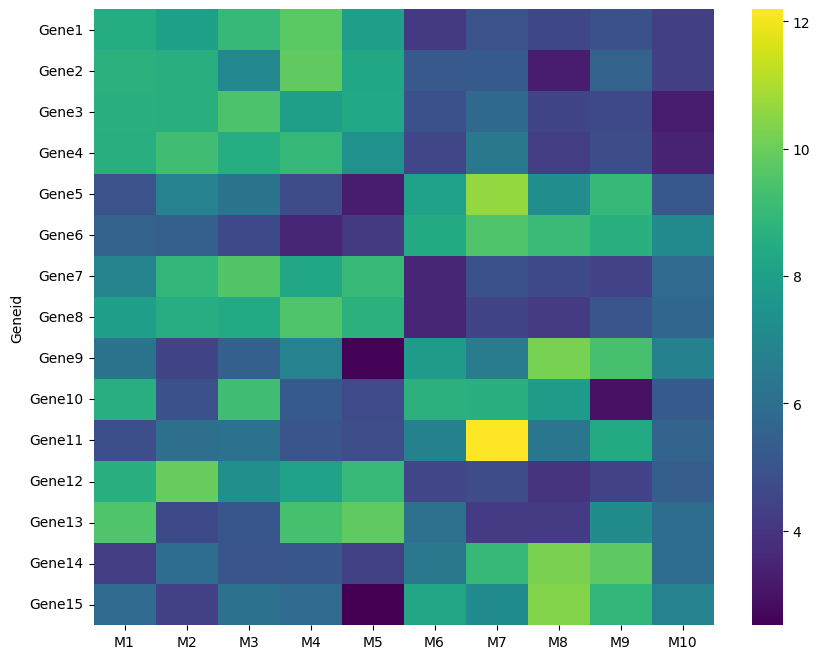

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go

df_sea = pd.read_csv('./demo_RPKM_1.txt',sep='\t').copy()
df_sea.set_index('Geneid', inplace=True)  # 假设基因名的列名是'Gene'

sns.clustermap(df_sea, method='average', cmap='viridis', figsize=(12, 10))

# 使用Seaborn创建热图
plt.figure(figsize=(10, 8))
sns.heatmap(df_sea, cmap='viridis')
plt.show()

# 将Seaborn热图转换为Plotly的交互式热图
data = df_sea.values
x_labels = df_sea.columns
y_labels = df_sea.index

trace = go.Heatmap(z=data, x=x_labels, y=y_labels, colorscale='Viridis')
fig = go.Figure(data=[trace])
fig.update_layout(
    title='基因表达谱交互式热图',
    xaxis=dict(title='样本'),
    yaxis=dict(title='基因')
)
fig.show()


### 方式1
- 显示方式不好，不如go方法

In [24]:
def heatmap(df, color, width=900, height=600, button='Z-score',transfer='Yes'):

    # df第一列改名为gene_id
    df = df.rename(columns={df.columns[0]: 'gene_id'})
    # 提取gene_id作为索引
    df = df.set_index('gene_id')
    # 只保留两位小数
    df = df.round(2)

    if button == 'centralization-column':
        # 列零均值化
        df_normalized = (df - df.mean(axis=0)) / (df.max(axis=0) - df.min(axis=0)) 
    elif button == 'centralization-line':
        # 每一行零均值化
        row_means = df.mean(axis=1) 
        df_normalized = df - row_means[:, np.newaxis]
    elif button == 'Z-score':
        # 归一化
        df_normalized = df.apply(lambda x: np.interp(x, (x.min(), x.max()), (-2, 2)))
    elif button == 'log2':
        df_normalized = np.log(df+1)
    elif button == 'log10':
        df_normalized = np.log10(df+1)
    else:
        df_normalized = df

    if transfer == 'Yes':
        # 转置
        df_normalized = df_normalized.transpose()

    # 创建热图
    fig = px.imshow(df_normalized,
                    labels=dict(x="Sample", y="Gene ID", color="Exp"),
                    x=df_normalized.columns,
                    y=df_normalized.index,
                    color_continuous_scale=color,
                   )

    # 定义鼠标悬浮数据显示方式
    fig.update_traces(hovertemplate='Gene: %{x}<br>Sample: %{y}<br>RPKM: %{z:.1f}')
    fig.update_layout(title='Gene expression heatmap')
    # 设置输出图的大小
    fig.update_layout(width=width, height=height)

    # # 将fig转为json格式，返回json数据
    # fig_json = json.dumps(fig, cls=PlotlyJSONEncoder)
    # return fig_json

    # 将fig转为html格式，返回html代码
    # plot_html = plot(fig, output_type='div', include_plotlyjs=False)        
    # return plot_html

    # 调试用
    return fig

# 调用函数
heatmap(df1, 'Rdbu_r', width=1200, height=900 ,button='Z-score',transfer='Yes')

### 方式2

In [25]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go

def create_heatmap(df, color='Rdbu_r'):
    # df第一列改名为gene_id
    df = df.rename(columns={df.columns[0]: 'gene_id'})
    # 提取gene_id作为索引
    df = df.set_index('gene_id')
    # 将数据进行归一化，范围-2到2
    df_normalized = df.apply(lambda x: np.interp(x, (x.min(), x.max()), (-2, 2)))
    
    # 创建热图
    fig = go.Figure(data=go.Heatmap(
        z=df_normalized,
        x=df_normalized.columns,
        y=df_normalized.index,
        colorscale=color,
        hovertemplate='Sample: %{x}<br>Gene: %{y}<br>Exp: %{z:.3f}<extra></extra>'
    ))
    # 设置轴标签
    fig.update_layout(
        xaxis_title="Sample",
        yaxis_title="Gene",
        width=1200,
        height=900,
    )

    return fig

create_heatmap(df)

### 添加聚类

In [3]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from scipy.cluster.hierarchy import linkage, leaves_list

def create_heatmap_with_clustering(df, color='RdBu_r'):

    # 第一列改名为gene_id，并设置为索引
    df = df.rename(columns={df.columns[0]: 'gene_id'})
    df = df.set_index('gene_id')

    # 数据归一化
    df_normalized = df.apply(lambda x: np.interp(x, (x.min(), x.max()), (-2, 2)))

    # 对基因（行）进行层次聚类
    gene_linkage = linkage(df_normalized, method='average')
    gene_order = leaves_list(gene_linkage)

    # 对样本（列）进行层次聚类
    sample_linkage = linkage(df_normalized.T, method='average')
    sample_order = leaves_list(sample_linkage)

    # 重排数据矩阵
    df_clustered = df_normalized.iloc[gene_order, sample_order]

    # 创建热图
    fig = go.Figure(data=go.Heatmap(
        z=df_clustered,
        x=df_clustered.columns,
        y=df_clustered.index,
        colorscale=color,
        hovertemplate='Sample: %{x}<br>Gene: %{y}<br>Exp: %{z:.3f}<extra></extra>'
    ))

    # 设置轴标签
    fig.update_layout(
        xaxis_title="Sample",
        yaxis_title="Gene",
        width=1200,
        height=900,
    )

    return fig

# 使用 create_heatmap_with_clustering(df) 来创建并显示聚类后的热图
create_heatmap_with_clustering(df1)


In [5]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from scipy.cluster.hierarchy import linkage, leaves_list

def create_heatmap_with_clustering(df, color='RdBu_r'):

    # 第一列改名为gene_id，并设置为索引
    df = df.rename(columns={df.columns[0]: 'gene_id'})
    df = df.set_index('gene_id')

    # 数据归一化
    df_normalized = df.apply(lambda x: np.interp(x, (x.min(), x.max()), (-2, 2)))

    # 对基因（行）进行层次聚类
    gene_linkage = linkage(df_normalized, method='average')
    gene_order = leaves_list(gene_linkage)

    # 对样本（列）进行层次聚类
    sample_linkage = linkage(df_normalized.T, method='average')
    sample_order = leaves_list(sample_linkage)

    # 重排数据矩阵
    df_clustered = df_normalized.iloc[gene_order, sample_order]

    # 创建热图
    fig = go.Figure(data=go.Heatmap(
        z=df_clustered,
        x=df_clustered.columns,
        y=df_clustered.index,
        colorscale=color,
        hovertemplate='Sample: %{x}<br>Gene: %{y}<br>Exp: %{z:.3f}<extra></extra>'
    ))

    # 设置轴标签
    fig.update_layout(
        xaxis_title="Sample",
        yaxis_title="Gene",
        width=1200,
        height=900,
    )

    return fig

# 使用 create_heatmap_with_clustering(df) 来创建并显示聚类后的热图
create_heatmap_with_clustering(df1)


### 添加聚类树

In [4]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from scipy.cluster.hierarchy import linkage, dendrogram
from plotly.figure_factory import create_dendrogram
from plotly.subplots import make_subplots

def create_heatmap_with_clustering_and_dendrogram(df, color='RdBu_r'):

    # 第一列改名为gene_id，并设置为索引
    df = df.rename(columns={df.columns[0]: 'gene_id'})
    df = df.set_index('gene_id')

    # 数据归一化
    df_normalized = df.apply(lambda x: np.interp(x, (x.min(), x.max()), (-2, 2)))

    # 对基因（行）进行层次聚类
    gene_linkage = linkage(df_normalized, method='average')
    gene_dendro = create_dendrogram(df_normalized, orientation='left', linkagefun=lambda x: gene_linkage)
    gene_order = leaves_list(gene_linkage)  # 获取基因的顺序

    # 对样本（列）进行层次聚类
    sample_linkage = linkage(df_normalized.T, method='average')
    sample_dendro = create_dendrogram(df_normalized.T, orientation='bottom', linkagefun=lambda x: sample_linkage)
    sample_order = leaves_list(sample_linkage)  # 获取样本的顺序

    # 重排数据矩阵
    df_clustered = df_normalized.iloc[gene_order, sample_order]

    # 创建含有多个子图的图形对象
    fig = make_subplots(
            rows=2, cols=2,
            column_widths=[0.15, 0.85],  # 调整树状图和热图的宽度比例
            row_heights=[0.85, 0.15],    # 调整树状图和热图的高度比例
            specs=[
                [{'type': 'scatter', 'rowspan': 2}, {'type': 'scatter'}],
                [None, {'type': 'heatmap'}]
            ],
            horizontal_spacing=0.005,  # 可以减小这个值来增大热图的空间
            vertical_spacing=0.005     # 可以减小这个值来增大热图的空间
        )


    for data in gene_dendro['data']:
        fig.add_trace(data, row=1, col=1)
        fig['data'][-1].update(showlegend=False)  # 这里移除图例

    for data in sample_dendro['data']:
        fig.add_trace(data, row=1, col=2)
        fig['data'][-1].update(showlegend=False)  # 这里移除图例


    # 添加热图到子图
    heatmap = go.Heatmap(
        z=df_clustered.values,  # 注意使用.values获取numpy数组
        x=df_clustered.columns.tolist(),  # 转换为列表确保兼容性
        y=df_clustered.index.tolist(),
        colorscale=color,
        hoverongaps=False,  # 可以选择关闭空白处的悬停效果
        hovertemplate='Sample: %{x}<br>Gene: %{y}<br>Exp: %{z:.3f}<extra></extra>'
    )
    fig.add_trace(heatmap, row=2, col=2)

    fig.update_layout(
        width=1200,  # 可以根据需要调整宽度
        height=900,  # 可以根据需要调整高度
        paper_bgcolor='white',  # 设置图表的背景颜色为白色
        plot_bgcolor='white',   # 设置图表内部的背景颜色为白色
        xaxis={'visible': False, 'showticklabels': False},
        xaxis2={'visible': False, 'showticklabels': False},
        yaxis={'visible': False, 'showticklabels': False},
        yaxis2={'visible': False, 'showticklabels': False}
    )

    fig.update_layout(
    xaxis={'domain': [0, 0.15]},  # 限制基因树状图的宽度
    yaxis={'domain': [0.15, 1]},  # 限制样本树状图的高度
    xaxis2={'domain': [0.15, 1], 'showticklabels': False},  # 限制热图的宽度，隐藏轴标签
    yaxis2={'domain': [0, 0.85], 'showticklabels': True},  # 限制热图的高度，隐藏轴标签
    )
    # 调整树状图线条的宽度
    for i in range(len(fig.data)):
        if 'marker' in fig.data[i]:
            fig.data[i].marker.line.width = 1  # 设置一个较小的线条宽度值

    return fig

# 使用 create_heatmap_with_clustering_and_dendrogram(df) 来创建并显示聚类后的热图和树状图
create_heatmap_with_clustering_and_dendrogram(df1)